In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import glob
import json
import numpy as np
import pandas as pd
import sqlite3 as sql
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from grid_search_graph import generate_plot

sns.set()

In [2]:
base_dir = "/tmp/grid_search"

results = glob.glob(os.path.join(base_dir, "*", "results.json"))

data = []
for i, r in enumerate(sorted(results)):
    with open(r, 'r') as f:
        j = json.load(f)
    j["nn_fps"] = int(np.mean(j["nn_fps"]))
    for k, v in j["config"].items():
        j[k] = v
    del j["config"]
    
    if "expansions" in j:
        del j["expansions"]
        
    for l, s in enumerate(j["layers_filters"]):
        j["layer{}_filter".format(l)] = s
    j["layers_filters"] = ",".join([str(s) for s in j["layers_filters"]])

    del j["last_mAP"]
    
    j["input_height"] = j["size_value"][0]
    j["input_width"] = j["size_value"][1]
    del j["size_value"]
    
    maps = defaultdict(int)
    for e, m in j['mAPs']:
        for th, v in m.items():
            maps[th] = max(maps[th], v)
    del j['mAPs']
#     for th, v in maps.items():
#         j["mAP@{}".format(th)] = v

    stats = {"TP": {}, "FP": {}, "FN": {}}
    e, (tp, fp, fn) = j["stats"][-1]
    for (th, tpv), fpv, fnv in zip(tp.items(), fp.values(), fn.values()):
        stats["TP"][th] = tpv
        stats["FP"][th] = fpv
        stats["FN"][th] = fnv
    del j['stats']
#     for name, values in stats.items():
#         for th, v in values.items():
#             j["{}@{}".format(name, th)] = v
    j["last_epoch"] = e
    j["test"] = i
    for th, v in maps.items():
        j_copy = {k: v for k, v in j.items()}
        for name, values in stats.items():
            j_copy[name] = values[th]
        j_copy["mAP"] = v
        j_copy["iou_threshold"] = th
        data.append(j_copy.values())

df = pd.DataFrame(data, columns=j_copy.keys())

con = sql.Connection(":memory:")

con.enable_load_extension(True)
con.load_extension("./extension-functions")

df.to_sql("glob_stats", con)

print(j.keys())

dict_keys(['nn_fps', 'prediction_count', 'flops', 'dropout_rate', 'dropout_strategy', 'layers_filters', 'layer0_filter', 'layer1_filter', 'layer2_filter', 'layer3_filter', 'input_height', 'input_width', 'last_epoch', 'test'])


Selecting data for iou_threshold = 0.25
Selecting data for iou_threshold = 0.5
Selecting data for iou_threshold = 0.75


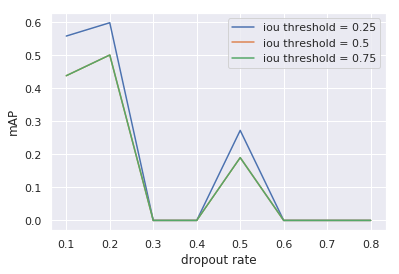

In [3]:
generate_plot(con, "dropout_rate", "mAP", "iou_threshold", {"dropout_strategy": ["last"]})

Selecting data for dropout_strategy = all
Selecting data for dropout_strategy = last


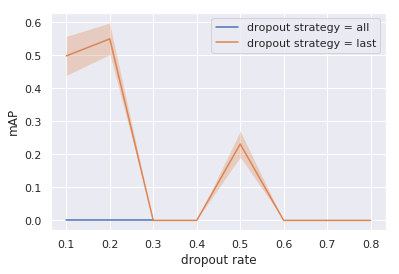

In [4]:
generate_plot(con, "dropout_rate", "mAP", "dropout_strategy", {"iou_threshold": [0.5,0.25]})

Selecting data for iou_threshold = 0.25
Selecting data for iou_threshold = 0.5
Selecting data for iou_threshold = 0.75


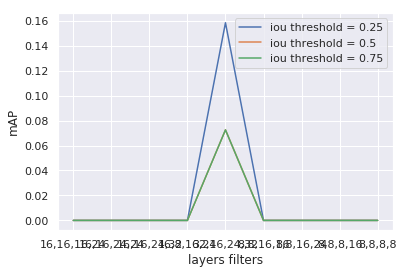

In [3]:
generate_plot(con, "layers_filters", "mAP", "iou_threshold", {})